In [1]:
from drain.model import Drain,Node,LogCluster
from drain.optimizer import Optimizer
from drain.plotter import createPlot
from drain.partition import Partition
from utils.data_utils import *
from unsupervised.model import Model,train
# from unsupervised.predictor import fast_predict
from torch import nn,optim
from torch.utils.data import  DataLoader

import pandas as pd
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 32
batch_size = 2048
input_size = 1
window_size = 10
num_layers = 2
hidden_size = 64

In [6]:
logPath = 'D:\\毕业设计\\loghub\\HDFS_1\\HDFS.log'
parsed_result = '.\\data\\parser\\log_item_to_label.csv'
cluster_result = '.\\data\\parser\\'
# partition
partition_output = '.\\data\\lstm\\dataset_official\\'
instance_file = 'instance.csv'
label_file = '.\\data\\partition\\anormaly_label.csv'
normal_output = 'normal.csv'
abnormal_output = 'abnormal.csv'
lstm_dataset = '.\\data\\lstm\\dataset_official\\'

In [7]:
model_dir = 'model'
version = 'v0.2'
model_name = 'unsupervise_lstm'
#'dev_v1.2_batch_size=2048_epoch=300'

model = Model(input_size, hidden_size, num_layers, num_classes).to(device)

if os.path.exists(model_dir + '/' + model_name + '.pt'):
    print('model exists:',model_name)
    model.load_state_dict(torch.load(model_dir + '/' + model_name + '.pt'))

model exists: unsupervise_lstm


In [8]:
model.eval()
batch_size = 20000
test_normal_session, test_normal_dataset, test_normal_seq, test_normal_label = generate_test_data(
    lstm_dataset + '/normal.csv', window_size)
normal_dataloader = DataLoader(test_normal_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_abnormal_session, test_abnormal_dataset, test_abnormal_seq, test_abnormal_label = generate_test_data(
    lstm_dataset + '/abnormal.csv', window_size)
abnormal_dataloader = DataLoader(test_abnormal_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

.\data\lstm\dataset\/normal.csv: 100%|████████████████████████████████████████| 14176/14176 [00:00<00:00, 16407.44it/s]


Number of sessions(.\data\lstm\dataset\/normal.csv): 14176
Number of seqs(.\data\lstm\dataset\/normal.csv): 269279


.\data\lstm\dataset\/abnormal.csv: 100%|████████████████████████████████████████| 4124/4124 [00:00<00:00, 15273.97it/s]

Number of sessions(.\data\lstm\dataset\/abnormal.csv): 4124
Number of seqs(.\data\lstm\dataset\/abnormal.csv): 88592


In [ ]:
def fast_predict(model,normal_dataloader,abnormal_dataloader,test_normal_session,test_abnormal_session,num_candidates=5,window_size=10,ts=0.0003):
    TP = 0
    FP = 0
    softmax = nn.Softmax(dim = 1)
    # Test the model
    start_time = time.time()
    test_normal_result = []
    test_abnormal_result = []
    with torch.no_grad():
        with torch.no_grad():
            for step, (seq, labels) in tqdm(enumerate(normal_dataloader), desc='normal'):
                seq = seq.clone().detach().view(-1, window_size, input_size).to(device)
                output = model(seq).cpu()
                output = output[:,-1,:]
                prob = softmax(output)
                predicted = torch.argsort(output, 1)[:,-num_candidates:]
                for i, label in enumerate(labels):
                    if label not in predicted[i] or prob[i][label]<ts:
                        test_normal_result.append(True)
                    else:
                        test_normal_result.append(False)
    for session in test_normal_session:
        for seq_id in session:
            if test_normal_result[seq_id] == True:
                FP += 1
                break

    with torch.no_grad():
        for step, (seq, labels) in tqdm(enumerate(abnormal_dataloader), desc='abnormal'):
            seq = seq.clone().detach().view(-1, window_size, input_size).to(device)
            output = model(seq).cpu()
            output = output[:,-1,:]
            prob = softmax(output)
            predicted = torch.argsort(output, 1)[:,-num_candidates:]
#             predicted = torch.argsort(output[:,-1,:], 1)[:,-num_candidates:]
            for i, label in enumerate(labels):
                if label not in predicted[i] or prob[i][label]<ts:
                    test_abnormal_result.append(True)
                else:
                    test_abnormal_result.append(False)
        for session in test_abnormal_session:
            for seq_id in session:
                if test_abnormal_result[seq_id] == True:
                    TP += 1
                    break
    elapsed_time = time.time() - start_time
    print('elapsed_time: {:.3f}s'.format(elapsed_time))
    # Compute precision, recall and F1-measure
    FN = len(test_abnormal_session) - TP
    P = 100 * TP / (TP + FP)
    R = 100 * TP / (TP + FN)
    F1 = 2 * P * R / (P + R)
    print('false positive (FP): {}, false negative (FN): {}, Precision: {:.3f}%, Recall: {:.3f}%, F1-measure: {:.3f}%'.format(FP, FN, P, R, F1))
    print('Finished Predicting')
    return test_normal_result,test_abnormal_result

In [ ]:
def generate_test_data(name,window_size=10):
    hdfs = set()
    data = pd.read_csv(name, engine='c', na_filter=False, memory_map=True)
    blockId_list= data['BlockId'].tolist()
    seqs = data['EventSequence'].apply(literal_eval).tolist()
    for ln in seqs:
        hdfs.add(tuple(ln))
        # hdfs.append(tuple(ln))
    session_to_seq = []
    seqs = []
    labels = []
    seq_count = 0
    for line in tqdm(hdfs, name):
        session = []
        line = [0]+list(line)+[30]
        line = line + [31] * (window_size + 1 - len(ln))
        for i in range(len(line) - window_size):
            seq = line[i:i + window_size]
            label = line[i + window_size]
            seqs.append(seq)
            session.append(seq_count)
            labels.append(label)
            seq_count += 1
        session_to_seq.append(session)
    print('Number of sessions({}): {}'.format(name, len(session_to_seq)))
    print('Number of seqs({}): {}'.format(name, len(seqs)))
    dataset = TensorDataset(torch.tensor(seqs, dtype=torch.float), torch.tensor(labels))
    return session_to_seq, dataset, seqs,labels

In [13]:
test_normal_result, test_abnormal_result = fast_predict(model, normal_dataloader, abnormal_dataloader,
                                                        test_normal_session, test_abnormal_session,
                                                        10, window_size)

normal: 14it [00:52,  3.75s/it]
abnormal: 5it [00:19,  3.85s/it]

elapsed_time: 71.758s
false positive (FP): 13648, false negative (FN): 5, Precision: 23.183%, Recall: 99.879%, F1-measure: 37.632%
Finished Predicting


In [10]:
test_normal_result, test_abnormal_result = fast_predict(model, normal_dataloader, abnormal_dataloader,
                                                        test_normal_session, test_abnormal_session,
                                                        10, window_size,ts=0.00005)

normal: 14it [00:54,  3.89s/it]
abnormal: 5it [00:18,  3.73s/it]

elapsed_time: 73.171s
false positive (FP): 14176, false negative (FN): 0, Precision: 22.536%, Recall: 100.000%, F1-measure: 36.782%
Finished Predicting


当前序列为: [0] 下一个可能出现event为: [22, 5]
判断分支情况 [22, 5]
发现不同的分支 [[22, 5]]
并发执行的分支 [22, 5]
发现循环 [5]
当前序列为: [22, 5] 下一个可能出现event为: [9, 26, 11]
判断分支情况 [9, 26, 11]
发现不同的分支 [[9, 26, 11]]
并发执行的分支 [9, 26, 11]
发现循环 [9]
发现循环 [26]
发现循环 [11]
当前序列为: [9, 26, 11] 下一个可能出现event为: [2, 3, 4, 23, 30]
判断分支情况 [2, 3, 4, 23, 30]
发现不同的分支 [[2, 3, 4], [23]]
并发执行的分支 [2, 3, 4]
发现循环 [2]
发现循环 [3]
发现循环 [4]
当前序列为: [2, 3, 4] 下一个可能出现event为: [23]
判断分支情况 [23]
发现不同的分支 [[23]]
当前序列为: [23] 下一个可能出现event为: [30, 21]
当前序列中存在循环结构 [23]
判断分支情况 [30, 21]
发现不同的分支 [[21]]
当前序列为: [21] 下一个可能出现event为: [30]
到达终止位置,结束 {30}
当前序列为: [23] 下一个可能出现event为: [30]
到达终止位置,结束 {30}
0 1 (0, 2)
0 2 (-0.5, 3)
1 2 (0.5, 3)
0 1 (0, 4)
0 1 (0, 5)
0 3 (-1, 6)
1 3 (0, 6)
2 3 (1, 6)
1 1 (0, 7)
0 2 (-0.5, 8)
1 2 (0.5, 8)
0 5 (-2, 9)
1 5 (-1, 9)
2 5 (0, 9)
0 1 (0, 10)
0 5 (1, 9)
2 5 (2, 9)


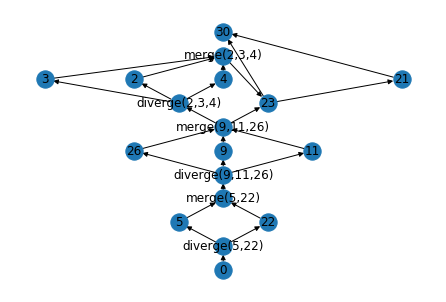

In [8]:
from unsupervised.wf_constructor import workflow_constructor,draw_wf
wf = workflow_constructor(model,input_size=1)
wf.generate_seq([1],1,3)
wf.workflow_construction([0],{30})
draw_wf(wf)

In [7]:
wf = workflow_constructor(model,input_size=1)

In [8]:
wf.generate_seq([23],1,3)

(tensor([[23., 26.]]),
 tensor([18, 21, 25,  3,  2,  4,  9, 26,  5, 11]),
 tensor([-5.1218, -5.8272,  1.4427,  1.4295,  1.6365,  5.7197, -1.0545, -4.8273,
         -4.9845,  1.9632, -5.3950,  6.1140, -4.8711, -5.4031, -5.5737, -5.5753,
         -7.7072, -5.3412, -0.0864, -5.2908, -4.8179,  0.0675, -2.8393, -0.9621,
         -5.2841,  0.8534,  3.4197, -4.9050, -4.7110, -4.6960, -5.8711],
        grad_fn=<ViewBackward>))

In [9]:
wf.workflow_construction([0],{30})

当前序列为: [0] 下一个可能出现event为: [2, 1]
判断分支情况 [2, 1]
发现不同的分支 [[2, 1]]
并发执行的分支 [2, 1]
发现循环 [1]
当前序列为: [2, 1] 下一个可能出现event为: [3, 4, 5]
判断分支情况 [3, 4, 5]
发现不同的分支 [[3, 4, 5]]
并发执行的分支 [3, 4, 5]
发现循环 [3]
发现循环 [4]
发现循环 [5]
当前序列为: [3, 4, 5] 下一个可能出现event为: [10, 11, 20, 22, 30]
判断分支情况 [10, 11, 20, 22, 30]
发现不同的分支 [[10, 11, 20, 22]]
并发执行的分支 [10, 11, 20, 22]
发现循环 [10]
发现循环 [11]
发现循环 [20]
发现循环 [22]
当前序列为: [10, 11, 20, 22] 下一个可能出现event为: [13, 30]
判断分支情况 [13, 30]
发现不同的分支 [[13]]
当前序列为: [13] 下一个可能出现event为: [30]
到达终止位置,结束 {30}


[0]

0 1 (0, 2)
0 2 (-0.5, 3)
1 2 (0.5, 3)
0 1 (0, 4)
0 1 (0, 5)
0 3 (-1, 6)
1 3 (0, 6)
2 3 (1, 6)
0 1 (0, 7)
0 1 (0, 8)
0 4 (-1.5, 9)
1 4 (-0.5, 9)
2 4 (0.5, 9)
3 4 (1.5, 9)
1 1 (0, 10)
0 1 (0, 11)
0 1 (0, 12)


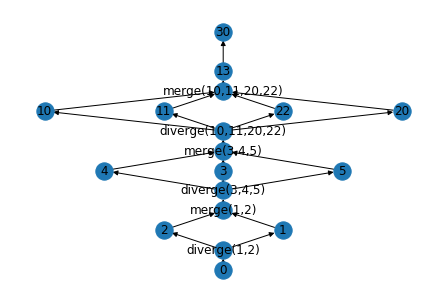

In [10]:
draw_wf(wf)

In [1]:
def split_data(file_dir):
    count = 0
    with open(file_dir+'/normal','r') as f:
        for i in f:
            count+=1
    print(4855/count)
    return 
    data_set = random_split(range(count),[4855,count-4855])
    f1 = open(file_dir+'/hdfs_test_normal','w')
    f2 = open(file_dir+'/hdfs_train','w')
    with open(file_dir+'/normal','r') as f:
        lines = f.readlines()
        for i in data_set[0]:
            f2.write(lines[i])
        for i in data_set[1]:
            f1.write(lines[i])
    f1.close()
    f2.close()

In [13]:
count = 0
with open('./data/lstm/dataset/normal.csv','r') as f:
    for i in f:
        count+=1
print(4855/count)

0.0087850724338722


In [14]:
def parse_log():

    rex = ['blk_(|-)[0-9]+', '(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)']
    removeCol = [0,1,2]
    myParser = Drain(rex=rex,removeCol=removeCol,st=0.4)
    myParser.fit(isReconstruct=True,inputFile=logPath,outputFile=parsed_result)

    myParser.save(savePath=cluster_result)

'''
partition phase
'''
def partition():

    partition = Partition(outputFileDir=partition_output,log_item_to_event_id_file=parsed_result,instances_file_path=instance_file,label_file_path=label_file,normal_output=normal_output,abnormal_output=abnormal_output)
    partition.partition_by_file()
    partition.map_log_seq_to_label()

    split_data(input_dir=partition_output,output_dir=lstm_dataset)

552642

In [12]:
count

552642